In [1]:
%matplotlib inline

import sys
sys.path.append('../src/')

import warnings
warnings.filterwarnings('ignore')

import cv2
import torch
import wider_dataset
import choke_point_dataset

import pandas as pd
import numpy as np
import seaborn as sns
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15, 10)

from benchmark.models import Detector
from benchmark.core import TsvHandle, run_detection, run_detection_video
from benchmark.stats import calc_precision_recall, calc_ap

# https://github.com/sthanhng/yoloface
from yoloface import get_outputs_names, post_process

# YoloFace Image detection

In [2]:
train, test, validation = tfds.load('wider_dataset', split=['train', 'test', 'validation'])
data = validation

In [3]:
class YoloFaceDetector(Detector):
    IMG_WIDTH = 416
    IMG_HEIGHT = 416

    CONF_THRESHOLD = 0.5
    NMS_THRESHOLD = 0.4
    
    def __init__(self):
        model_cfg = '../src/yoloface/cfg/yolov3-face.cfg'
        model_weights = '../src/yoloface/model-weights/yolov3-wider_16000.weights'
        
        self.detector = cv2.dnn.readNetFromDarknet(model_cfg, model_weights)
        self.detector.setPreferableBackend(cv2.dnn.DNN_BACKEND_OPENCV)
        self.detector.setPreferableTarget(cv2.dnn.DNN_TARGET_CPU)
    
    def detect(self, image):
        blob = cv2.dnn.blobFromImage(image, 1 / 255, (self.IMG_WIDTH, self.IMG_HEIGHT),
                                     [0, 0, 0], 1, crop=False)
        self.detector.setInput(blob)
        outs = self.detector.forward(get_outputs_names(self.detector))

        boxes, confidence = post_process(image, outs, self.CONF_THRESHOLD, self.NMS_THRESHOLD)

        return boxes, confidence
    
yolo_face = YoloFaceDetector()

In [4]:
with TsvHandle('yoloface') as tsv:
    path, ap_path, load_path, meta_path = run_detection(
        tsv_handle = tsv, 
        samples = data, 
        detector = yolo_face, 
        cv2_filter = cv2.COLOR_RGB2BGR, 
        use_width_height = True
    )

print("")
print(path)
print(ap_path)
print(load_path)
print(meta_path)

Running detection
[====================] 100% [2/2]
./results/yoloface-20220613-163653.tsv
./results/yoloface-20220613-163653-ap.tsv
./results/yoloface-20220613-163653-load.tsv
./results/yoloface-20220613-163653-metadata.tsv


In [5]:
with TsvHandle('yoloface_filtered') as tsv:
    path_filtered, ap_path_filtered, load_path_filtered, meta_path_filtered = run_detection(
        tsv_handle = tsv, 
        samples = data, 
        detector = yolo_face, 
        cv2_filter = cv2.COLOR_RGB2BGR, 
        use_width_height = True,
        filter_area = 2000)

print("")
print(path_filtered)
print(ap_path_filtered)
print(load_path_filtered)
print(meta_path_filtered)

Running detection
[====================] 100% [2/2]
./results/yoloface_filtered-20220613-163718.tsv
./results/yoloface_filtered-20220613-163718-ap.tsv
./results/yoloface_filtered-20220613-163718-load.tsv
./results/yoloface_filtered-20220613-163718-metadata.tsv


# Results

In [6]:
df = pd.read_csv(path, sep='\t', header=0, parse_dates=["Timestamp"])
df_filtered = pd.read_csv(path_filtered, sep='\t', header=0, parse_dates=["Timestamp"])

df_ap = pd.read_csv(ap_path, sep='\t', header=0)
df_ap = df_ap.sort_values(by=['Confidence'], ignore_index=True, ascending=False)

df_ap_filtered = pd.read_csv(ap_path_filtered, sep='\t', header=0)
df_ap_filtered = df_ap_filtered.sort_values(by=['Confidence'], ignore_index=True, ascending=False)

df_load = pd.read_csv(load_path, sep='\t', header=0, parse_dates=["Timestamp"])
df_meta = pd.read_csv(meta_path, sep='\t', header=0)

In [7]:
df_meta

,Python,CPU,GPUs
0,3.8.8.final.0 (64 bit),AMD Ryzen 7 2700X Eight-Core Processor,"['device: 0, name: NVIDIA GeForce GTX 1080 Ti,..."


In [8]:
df_load

,Timestamp,CPU_Load,RAM_Avail
0,2022-06-13 16:36:53.489430,11.5,3470499840
1,2022-06-13 16:37:05.170929,18.4,2843164672


In [9]:
def plot_data_over_time(time, data, label):
    plt.plot(time, data)
    plt.xlabel('Time') 
    plt.ylabel(label)
    plt.grid(True)
    plt.show()

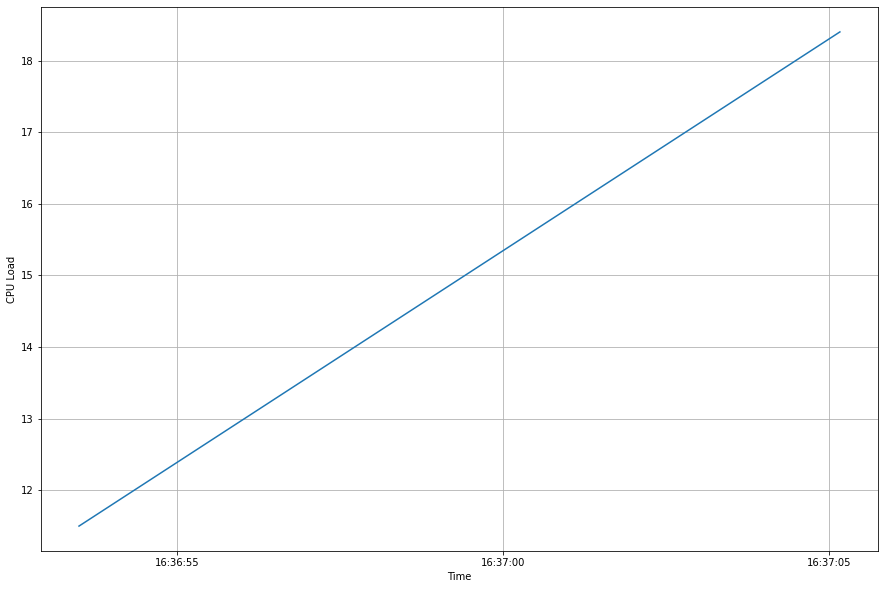

In [10]:
plot_data_over_time(df_load['Timestamp'], df_load['CPU_Load'], 'CPU Load')

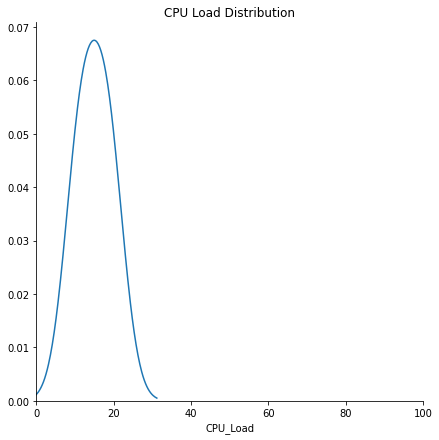

In [11]:
sns.FacetGrid(df_load, height=6).map(sns.kdeplot, 'CPU_Load').add_legend()
plt.title('CPU Load Distribution')
plt.xlim(0, 100)
plt.show()

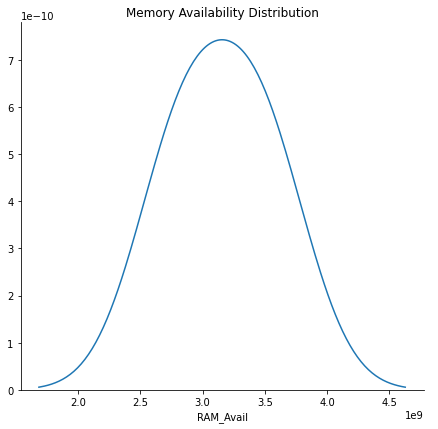

In [12]:
sns.FacetGrid(df_load, height=6).map(sns.kdeplot, 'RAM_Avail').add_legend()
plt.title('Memory Availability Distribution')
plt.show()

In [13]:
df

,Timestamp,Speed,Precision,Recall,F1_Score,Ious,Positives,False_Positives,Negatives,Num_Of_Faces,Predicted,Ground_Truth
0,2022-06-13 16:36:54.692929,640353800,1.0,0.875,0.933333,"[0.7788707204905467, 0.856114272442225, 0.8571...",7,0,1,8,"[(788.0, 192.0, 855.0, 283.0), (178.0, 146.0, ...","[(909.0, 335.0, 974.0, 418.0), (786.0, 187.0, ..."
1,2022-06-13 16:36:55.149930,449963800,0.0,0.000,0.000000,[],0,0,1,1,[],"[(547.0, 1228.0, 688.0, 1333.0)]"


In [14]:
df.describe()

,Speed,Precision,Recall,F1_Score,Positives,False_Positives,Negatives,Num_Of_Faces
count,2.000000e+00,2.000000,2.000000,2.000000,2.000000,2.0,2.0,2.000000
mean,5.451588e+08,0.500000,0.437500,0.466667,3.500000,0.0,1.0,4.500000
std,1.346261e+08,0.707107,0.618718,0.659966,4.949747,0.0,0.0,4.949747
min,4.499638e+08,0.000000,0.000000,0.000000,0.000000,0.0,1.0,1.000000
25%,4.975613e+08,0.250000,0.218750,0.233333,1.750000,0.0,1.0,2.750000
50%,5.451588e+08,0.500000,0.437500,0.466667,3.500000,0.0,1.0,4.500000
75%,5.927563e+08,0.750000,0.656250,0.700000,5.250000,0.0,1.0,6.250000
max,6.403538e+08,1.000000,0.875000,0.933333,7.000000,0.0,1.0,8.000000


In [15]:
speed = df['Speed'].div(1e6).round(2)
speed.describe()

count      2.00000
mean     545.15500
std      134.62606
min      449.96000
25%      497.55750
50%      545.15500
75%      592.75250
max      640.35000
Name: Speed, dtype: float64

### Generate Precision/Recall columns

In [16]:
all_gts = df['Positives'].sum() + df['Negatives'].sum()
df_ap = calc_precision_recall(df_ap, all_gts)

df_ap

,Confidence,TP_FP@25,TP_FP@50,TP_FP@75,Precision@25,Recall@25,Precision@50,Recall@50,Precision@75,Recall@75
0,0.999553,True,True,True,1.0,0.111111,1.0,0.111111,1.000000,0.111111
1,0.999539,True,True,True,1.0,0.222222,1.0,0.222222,1.000000,0.222222
2,0.999454,True,True,True,1.0,0.333333,1.0,0.333333,1.000000,0.333333
3,0.998841,True,True,True,1.0,0.444444,1.0,0.444444,1.000000,0.444444
4,0.998141,True,True,True,1.0,0.555556,1.0,0.555556,1.000000,0.555556
5,0.995499,True,True,True,1.0,0.666667,1.0,0.666667,1.000000,0.666667
6,0.965221,True,True,False,1.0,0.777778,1.0,0.777778,0.857143,0.666667


In [17]:
all_gts_filtered = df_filtered['Positives'].sum() + df_filtered['Negatives'].sum()
df_ap_filtered = calc_precision_recall(df_ap_filtered, all_gts_filtered)

df_ap_filtered

,Confidence,TP_FP@25,TP_FP@50,TP_FP@75,Precision@25,Recall@25,Precision@50,Recall@50,Precision@75,Recall@75
0,0.999553,True,True,True,1.0,0.111111,1.0,0.111111,1.000000,0.111111
1,0.999539,True,True,True,1.0,0.222222,1.0,0.222222,1.000000,0.222222
2,0.999454,True,True,True,1.0,0.333333,1.0,0.333333,1.000000,0.333333
3,0.998841,True,True,True,1.0,0.444444,1.0,0.444444,1.000000,0.444444
4,0.998141,True,True,True,1.0,0.555556,1.0,0.555556,1.000000,0.555556
5,0.995499,True,True,True,1.0,0.666667,1.0,0.666667,1.000000,0.666667
6,0.965221,True,True,False,1.0,0.777778,1.0,0.777778,0.857143,0.666667


In [18]:
def plot_pr(df_data, title):
    ap = calc_ap(df_data['Precision@25'], df_data['Recall@25'])
    plt.plot(df_data['Recall@25'], df_data['Precision@25'], color='darkcyan', lw=3, label="AP@0.25=%.2f" % ap)
    plt.axvline(x = df_data['Recall@25'][df_data.index[-1]], ymax=df_data['Precision@25'][df_data.index[-1]], color = 'darkcyan')
    
    ap = calc_ap(df_data['Precision@50'], df_data['Recall@50'])
    plt.plot(df_data['Recall@50'], df_data['Precision@50'], color='darkorange', lw=3, label="AP@0.5=%.2f" % ap)
    plt.axvline(x = df_data['Recall@50'][df_data.index[-1]], ymax=df_data['Precision@50'][df_data.index[-1]], color = 'darkorange')
    
    ap = calc_ap(df_data['Precision@75'], df_data['Recall@75'])
    plt.plot(df_data['Recall@75'], df_data['Precision@75'], color='mediumorchid', lw=3, label="AP@0.75=%.2f" % ap)
    plt.axvline(x = df_data['Recall@75'][df_data.index[-1]], ymax=df_data['Precision@75'][df_data.index[-1]], color = 'mediumorchid')
    
    plt.xlim(0, 1.00)
    plt.ylim(0, 1.00)

    plt.title(title)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend(loc="lower right", prop={'size': 16})
    plt.grid(True)

    plt.show()

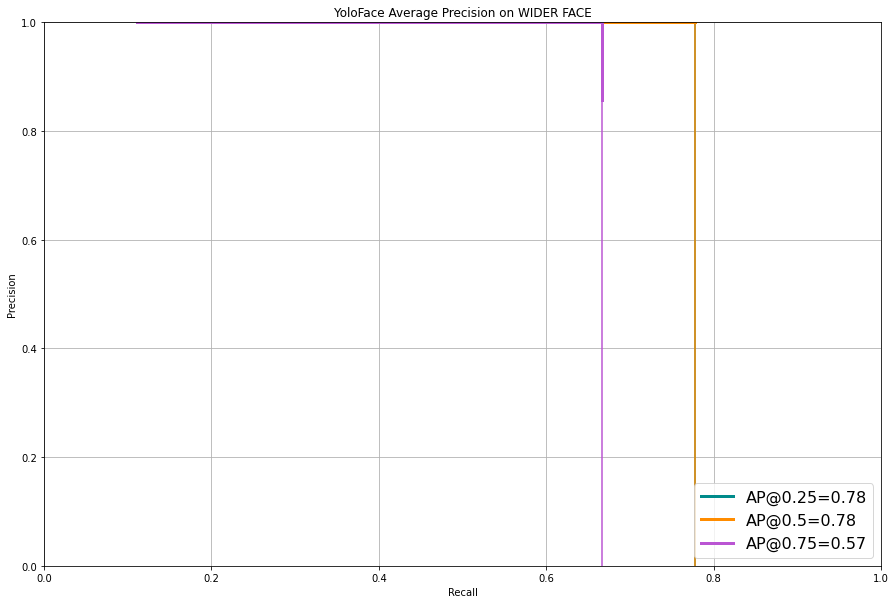

In [19]:
plot_pr(df_ap, 'YoloFace Average Precision on WIDER FACE')

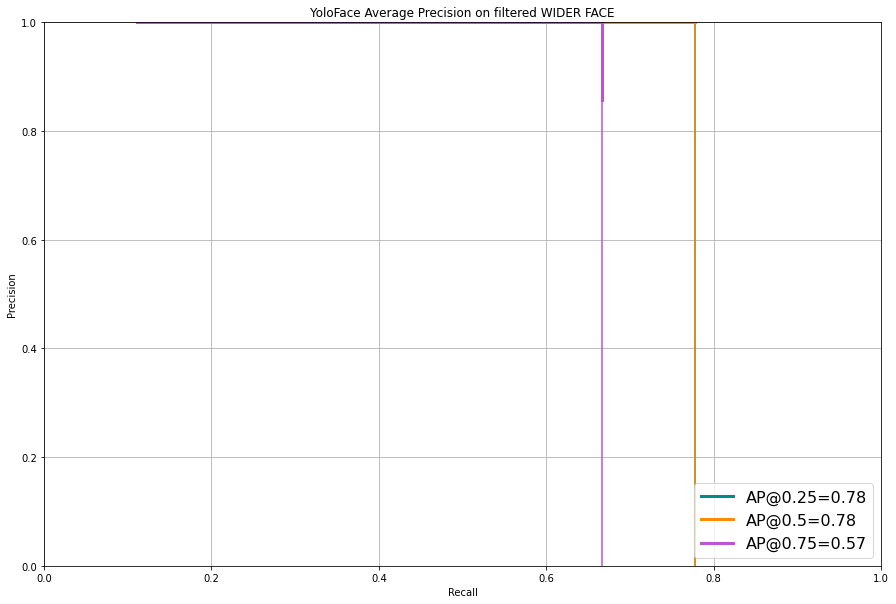

In [20]:
plot_pr(df_ap_filtered, 'YoloFace Average Precision on filtered WIDER FACE')

# YoloFace Video detection

In [21]:
test = tfds.load('choke_point', split=['test'])

In [25]:
data = test[0]

In [26]:
class YoloFaceDetector(Detector):
    IMG_WIDTH = 416
    IMG_HEIGHT = 416

    CONF_THRESHOLD = 0.5
    NMS_THRESHOLD = 0.4
    
    def __init__(self):
        model_cfg = '../src/yoloface/cfg/yolov3-face.cfg'
        model_weights = '../src/yoloface/model-weights/yolov3-wider_16000.weights'
        
        self.detector = cv2.dnn.readNetFromDarknet(model_cfg, model_weights)
        self.detector.setPreferableBackend(cv2.dnn.DNN_BACKEND_OPENCV)
        self.detector.setPreferableTarget(cv2.dnn.DNN_TARGET_CPU)
    
    def detect(self, image):
        blob = cv2.dnn.blobFromImage(image, 1 / 255, (self.IMG_WIDTH, self.IMG_HEIGHT),
                                     [0, 0, 0], 1, crop=False)
        self.detector.setInput(blob)
        outs = self.detector.forward(get_outputs_names(self.detector))

        boxes, confidence = post_process(image, outs, self.CONF_THRESHOLD, self.NMS_THRESHOLD)

        return boxes, confidence
    
yolo_face = YoloFaceDetector()

Frames: [==                  ] 13% [6/45], Videos: [1/2]

KeyboardInterrupt: 

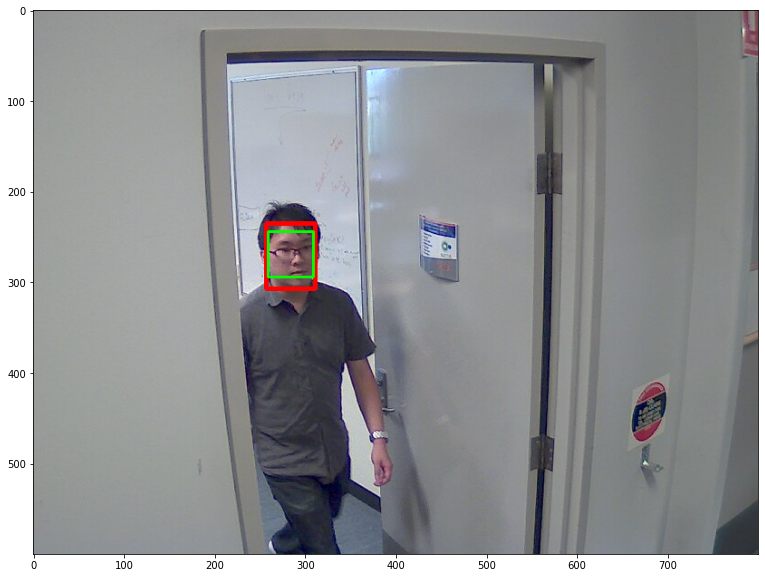

In [27]:
stt_aps, detection_percentages, mean_confidences, mean_inference_times = run_detection_video(
    samples=data, 
    detector=yolo_face,
    results_folder="yoloface",
    use_width_height=True,
    display_results=False,
    save_videos=True
)

In [ ]:
print("Mean Video STT-AP: {0:.2f}".format(np.mean(stt_aps)))
print("Mean detection percentage of faces in all videos: {:.2f}".format(np.mean(detection_percentages)))
print("Mean confidence of boxes in all videos: {:.2f}".format(np.mean(mean_confidences)))
print("Mean inference time for all frames: {:.2f}ms".format(np.mean(mean_inference_times) / 1e+6))